In [ ]:
import numpy as np  # Import the NumPy library (for numerical operations)
import pickle as pkl  # Import the Pickle library (for serializing objects)
import tensorflow as tf  # Import the TensorFlow library (for deep learning)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input  # Import ResNet50 model and preprocessing function
from tensorflow.keras.preprocessing import image  # Import Keras's image preprocessing module
from tensorflow.keras.layers import GlobalMaxPool2D  # Import GlobalMaxPool2D layer

from sklearn.neighbors import NearestNeighbors  # Import the NearestNeighbors class from Scikit-learn
import os  # Import the os module (for interacting with the operating system)
from numpy.linalg import norm  # Import the norm function from NumPy's linear algebra module
import random  # Import the random module (for random selection)
from transformers import AutoFeatureExtractor

In [ ]:
YOLO_MODEL_PATH = "../../yolo_small"
FINETUNED_MODEL_PATH = "../../model"
IMAGE_PATH = "https://i.pinimg.com/474x/d0/53/b7/d053b7bb55aa0c458bbdba42e5920726.jpg"
CAT_NAME = "pants"

In [ ]:
# Collecting Image File Paths
filenames = []  # Create an empty list to store the file paths of the images
for file in os.listdir('../../dataset/images'):
    filenames.append(os.path.join('../../dataset/images', file))  # Add full file path to the list

# Printing the Number of Files
len(filenames)  # Print the number of files


44441

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

In [ ]:
# Loading and Customizing the ResNet50 Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Load the ResNet50 model with pretrained weights ('imagenet'), exclude the top classification layer, and set input size to (224, 224, 3)

model.trainable = False  # Freeze the model (disable training for the ResNet50 layers)

model = tf.keras.models.Sequential([model,  # Create a Sequential model and add the ResNet50 model
                                   GlobalMaxPool2D()  # Add a GlobalMaxPool2D layer to reduce feature dimensions
                                   ])

model.summary()  # Print the model summary


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
def extract_features_from_images(image_path, model):
    # Function to extract features from images

    img = image.load_img(image_path, target_size=(224,224))
    # Load the image and resize it to (224, 224)

    img_array = image.img_to_array(img)
    # Convert the image to a NumPy array

    img_expand_dim = np.expand_dims(img_array, axis=0)
    # Add an extra dimension to match the input shape expected by the model

    img_preprocess = preprocess_input(img_expand_dim)
    # Preprocess the image (normalize pixel values as expected by ResNet50)

    result = model.predict(img_preprocess, verbose=0).flatten()
    # Use the model to extract features and flatten the output

    norm_result = result / norm(result)
    # Normalize the result using the vector norm

    return norm_result
    # Return the normalized result

# Test feature extraction with the first image
extract_features_from_images(filenames[0], model)


array([0.        , 0.01761617, 0.00171604, ..., 0.01247241, 0.02726403,
       0.06899223], dtype=float32)

In [ ]:
from rich.progress import Progress, TimeElapsedColumn, TimeRemainingColumn, BarColumn, TextColumn

image_features = []

# Create a rich progress bar with estimated time remaining
with Progress(
    TextColumn("[cyan]{task.description}"),
    BarColumn(),  # Display the progress bar
    TextColumn("{task.completed}/{task.total}"),  # Display processed/total files
    TimeElapsedColumn(),  # Display the formatted elapsed time
    TimeRemainingColumn(),  # Display the estimated time remaining
) as progress:
    task = progress.add_task("Extracting Features...", total=len(filenames))

    for file in filenames:
        features = extract_features_from_images(file, model)
        # Extract features from each file

        if features is not None:
            image_features.append(features)
            # Add the extracted features to the list

        progress.update(task, advance=1)  # Update the progress bar by 1 step

print(f"\n[green]Total processed files: {len(image_features)}")
# Print the total number of processed files in green color


Output()

KeyboardInterrupt: 

In [ ]:
# Save extracted features to a file
Image_features = pkl.dump(image_features, open('Images_features.pkl', 'wb'))

# Save file names to a file
filenames = pkl.dump(filenames, open('filenames.pkl', 'wb'))



### Run From Here if features are already extaracted 

In [ ]:
# Load saved features from the file
Image_features = pkl.load(open('Images_features.pkl', 'rb'))

# Load saved file names from the file
filenames = pkl.load(open('filenames.pkl', 'rb'))

# Check the shape of the feature vectors
np.array(Image_features).shape


(44441, 2048)

In [ ]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
# Create a NearestNeighbors model with 6 neighbors, using brute-force search and Euclidean distance

neighbors.fit(Image_features)
# Fit the model using the extracted image features


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

In [ ]:
input_image = extract_features_from_images('./shopping.jpg', model)
# Extract features from the input image

distance, indices = neighbors.kneighbors([input_image])
# Find the nearest neighbors of the input image

indices[0]
# Print the indices of the nearest neighbors found


array([40280, 40508, 38199, 24828, 38475, 35415])

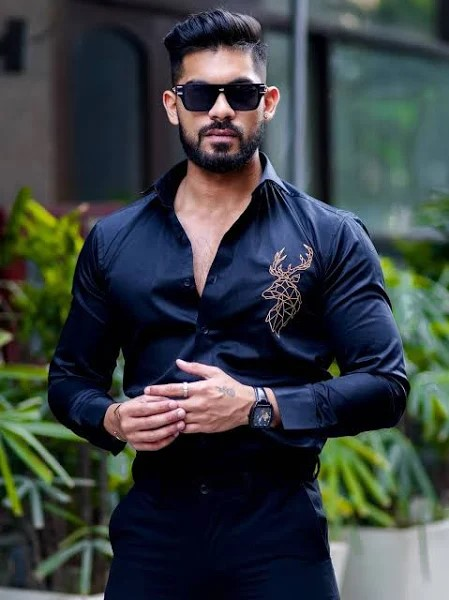

Similar Products:



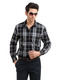

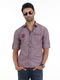

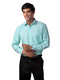

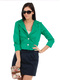

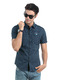

In [ ]:
from IPython.display import Image
# Import the Image class from the IPython.display library

display(Image('./shopping.jpg'))
# Display the input image

print("Similar Products:\n")

display(Image(filenames[indices[0][1]]))
# Display the most similar image (first nearest neighbor)

display(Image(filenames[indices[0][2]]))
# Display the second most similar image

display(Image(filenames[indices[0][3]]))
# Display the third most similar image

display(Image(filenames[indices[0][4]]))
# Display the fourth most similar image

display(Image(filenames[indices[0][5]]))
# Display the fourth most similar image